In [70]:
import time

import tensorflow as tf
import pandas as pd

from window import WindowGenerator
import utils

# LSTM

## Datasets

In [71]:
case_1 = pd.read_csv("../datasets/case_1.csv", index_col='Time')
case_2 = pd.read_csv("../datasets/case_2.csv", index_col='Time')
case_3 = pd.read_csv("../datasets/case_3.csv", index_col='Time')
case_4 = pd.read_csv("../datasets/case_4.csv", index_col='Time')
case_5 = pd.read_csv("../datasets/case_5.csv", index_col='Time')

In [72]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

num_features = len(label_columns)

In [73]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Train case function

In [74]:
def train_case(case_df:pd.DataFrame, model, in_width:int, out_steps:int, max_epochs:int):
    """ Train model for given case dataframe. """

    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = utils.train_test_val_split(case_df, test_size=0, val_size=0.2)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

## Model creation

In [75]:
IN_WIDTH = 18
OUT_STEPS = 18
MAX_EPOCHS = 30
features_size = len(label_columns)

In [76]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [77]:
multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                         optimizer=tf.optimizers.Adam(),
                         metrics=[tf.metrics.RootMeanSquaredError()])

In [78]:
exec_times = {}

In [ ]:
results = {}

## Case 2

In [79]:
start_t = time.time()

window, history = train_case(
    case_df=case_2,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_2'] = time.time() - start_t

2022-09-27 16:36:45.283951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-27 16:36:45.492152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-27 16:36:45.753155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-27 16:36:46.289668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-27 16:36:46.357964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [80]:
multi_lstm_model.build(input_shape=window.example[0].shape)
multi_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                39040     
                                                                 
 dense_3 (Dense)             (None, 2448)              80784     
                                                                 
 reshape_3 (Reshape)         (None, 18, 136)           0         
                                                                 
Total params: 119,824
Trainable params: 119,824
Non-trainable params: 0
_________________________________________________________________


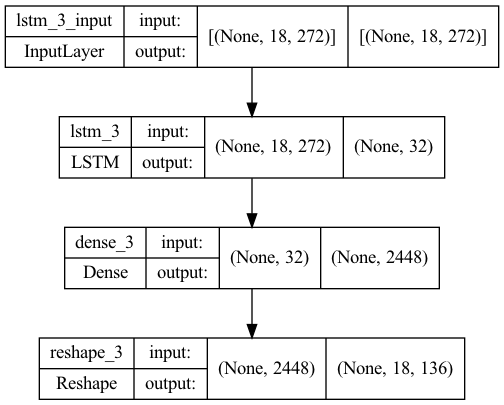

In [81]:
tf.keras.utils.plot_model(multi_lstm_model, "../plots/models/multi_lstm_model.png", show_shapes=True)

label_col_index 135


2022-09-27 16:36:59.455297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-27 16:36:59.511304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


label_col_index 135
label_col_index 135


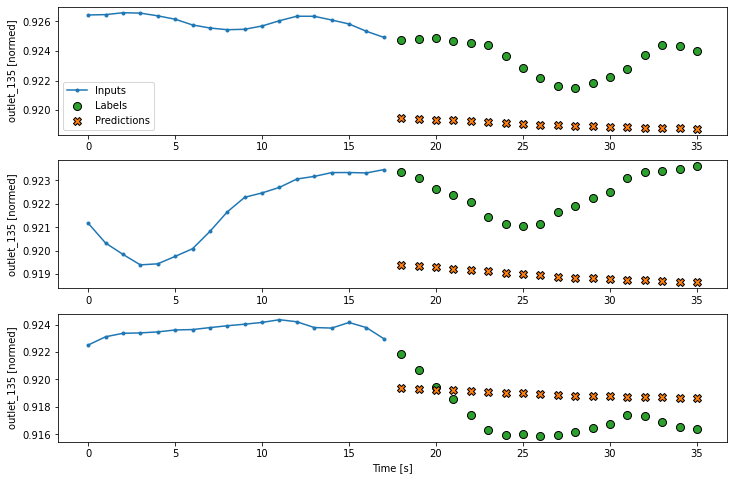

In [82]:
window.plot(multi_lstm_model, plot_col="outlet_135")

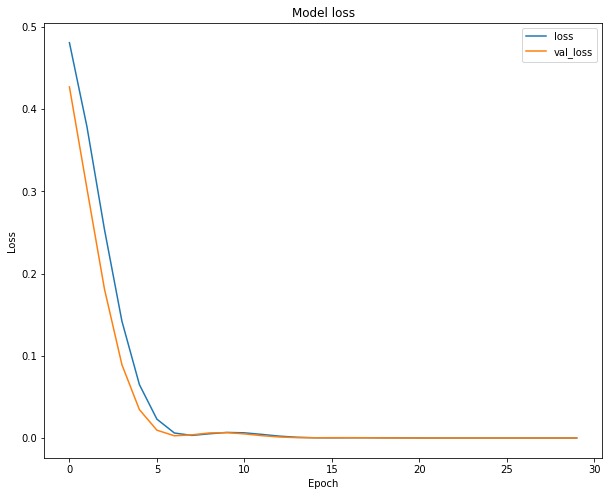

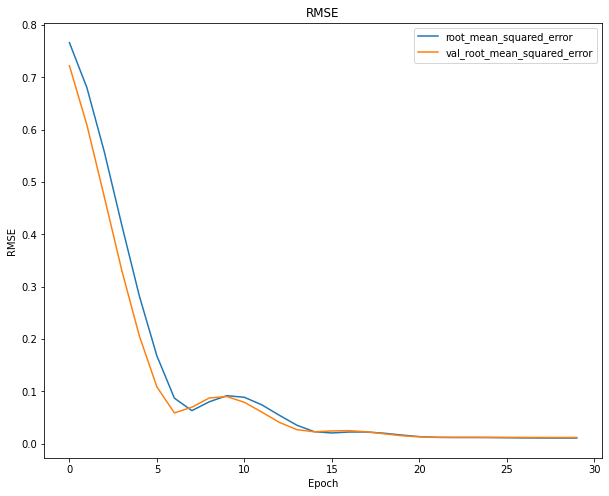

In [83]:
utils.plot_losses(history=history)

In [ ]:
results['case_2'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 3

In [84]:
start_t = time.time()

window, history = train_case(
    case_df=case_3,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_3'] = time.time() - start_t

label_col_index 135
label_col_index 135
label_col_index 135


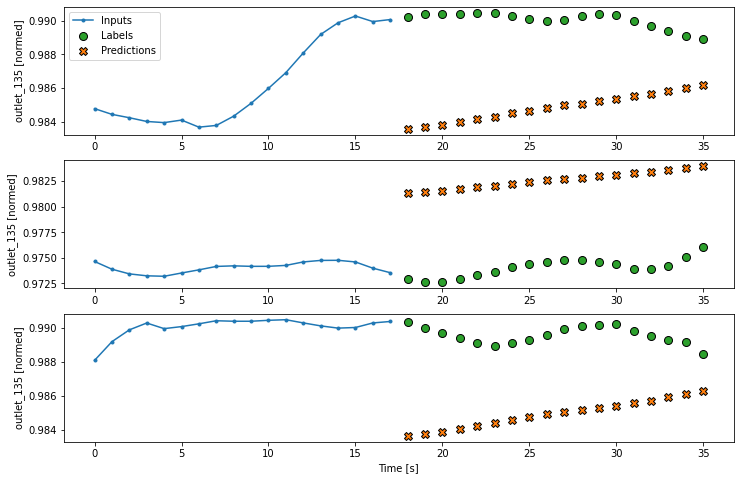

In [85]:
window.plot(multi_lstm_model, plot_col="outlet_135")

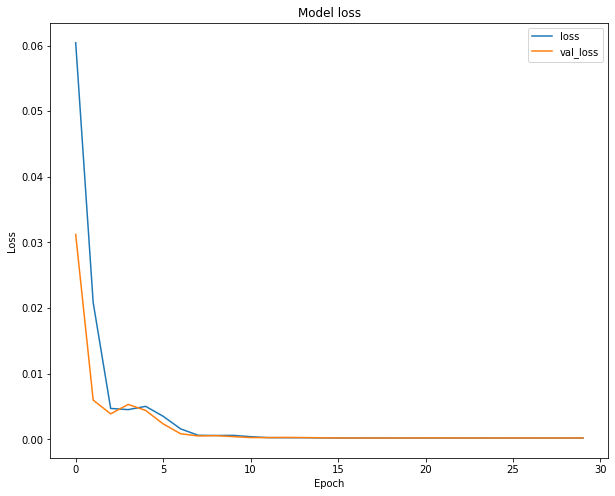

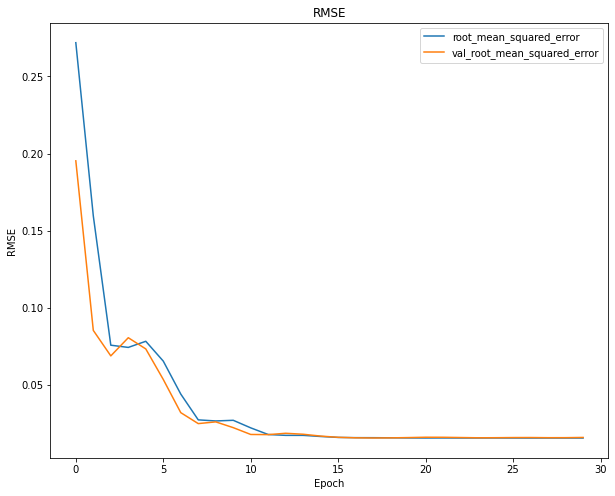

In [86]:
utils.plot_losses(history=history)

In [ ]:
results['case_3'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 4

In [87]:
start_t = time.time()

window, history = train_case(
    case_df=case_4,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_4'] = time.time() - start_t

label_col_index 135
label_col_index 135
label_col_index 135


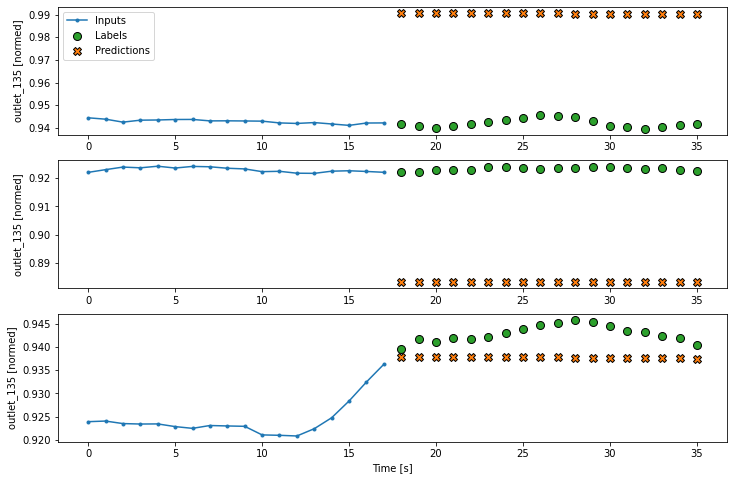

In [88]:
window.plot(multi_lstm_model, plot_col="outlet_135")

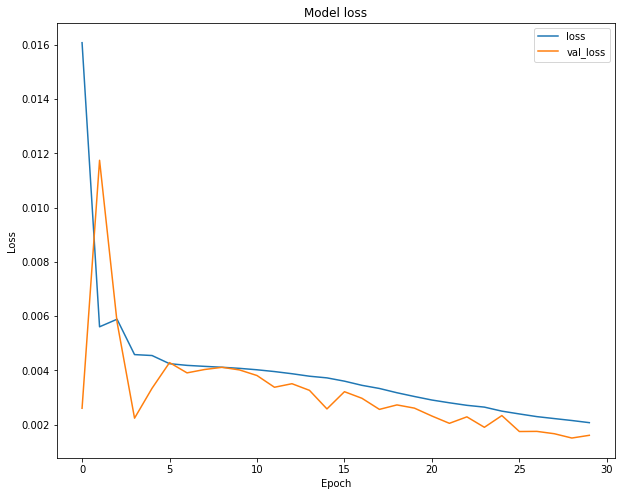

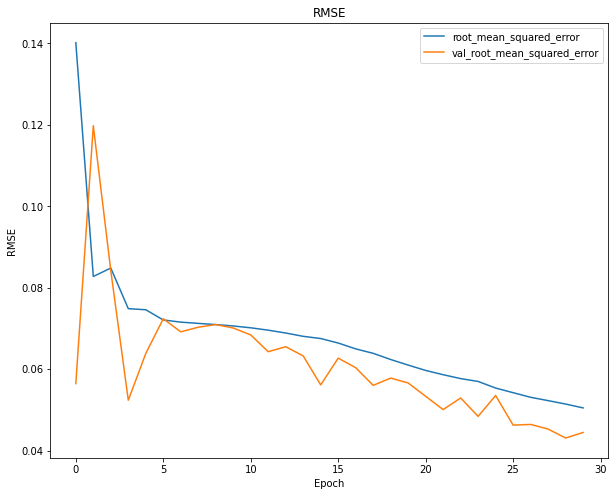

In [89]:
utils.plot_losses(history=history)

In [ ]:
results['case_4'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 5

In [90]:
start_t = time.time()

window, history = train_case(
    case_df=case_5,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_5'] = time.time() - start_t

label_col_index 135
label_col_index 135
label_col_index 135


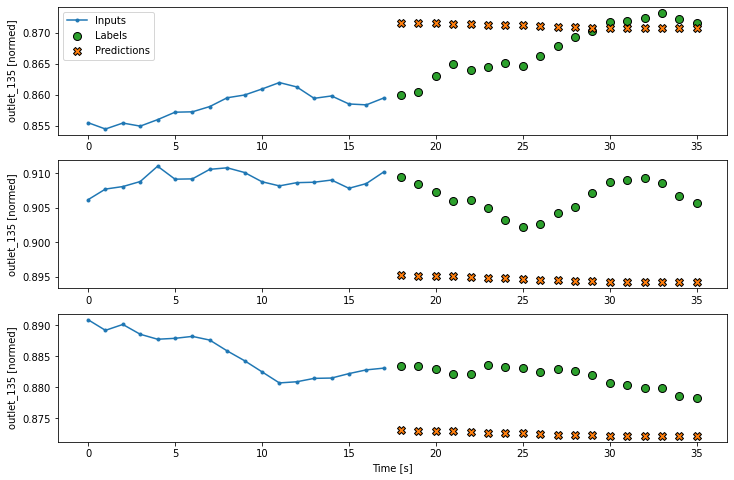

In [91]:
window.plot(multi_lstm_model, plot_col="outlet_135")

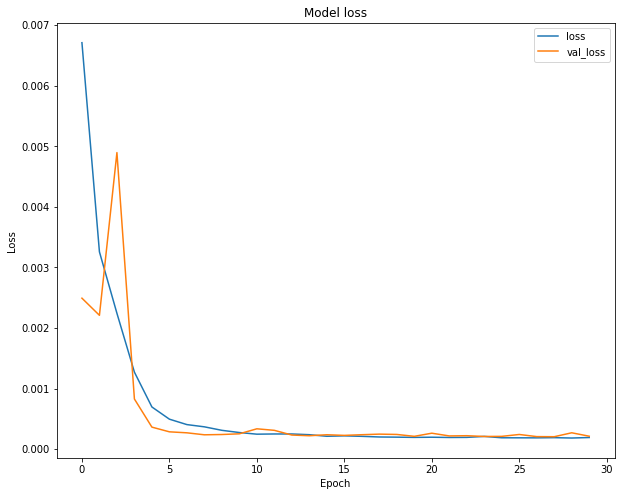

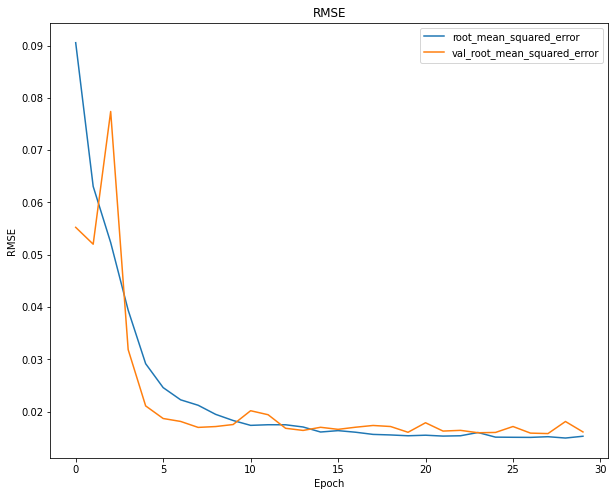

In [92]:
utils.plot_losses(history=history)

In [ ]:
results['case_5'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 1 (Testing)

In [93]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
column_indices = { name: i for i, name in enumerate(case_1.columns) }

label_columns = outlets

window = WindowGenerator(
    train_df=case_1,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=label_columns
)

test_res = multi_lstm_model.evaluate(window.train)

5/5 [==============================] - 0s 13ms/step - loss: 0.0213 - root_mean_squared_error: 0.1615


[0.021327020600438118, 0.16145417094230652]

In [ ]:
results['test'] = {
    'loss': test_res[0],
    'rmse': test_res[1]
}

In [ ]:
pd.DataFrame(results).transpose()

In [94]:
exec_times = pd.DataFrame().from_dict(exec_times, orient='index', columns=['Time'])
exec_times

,Time
case_2,15.369569
case_3,14.718828
case_4,15.672608
case_5,20.019920


In [95]:
print("Total: ", exec_times['Time'].sum())

Total:  65.7809247970581
